In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.utils.sigma_estimation import estimate_diffusion_unprocessed

#### Loading AAPL data

/tmp/ipykernel_22139/484583999.py:27: DtypeWarning: Columns (1,2,4,5,6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_options = pd.read_csv(
/tmp/ipykernel_22139/484583999.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_options['mid_price'] = df_options['mid_price'].bfill()


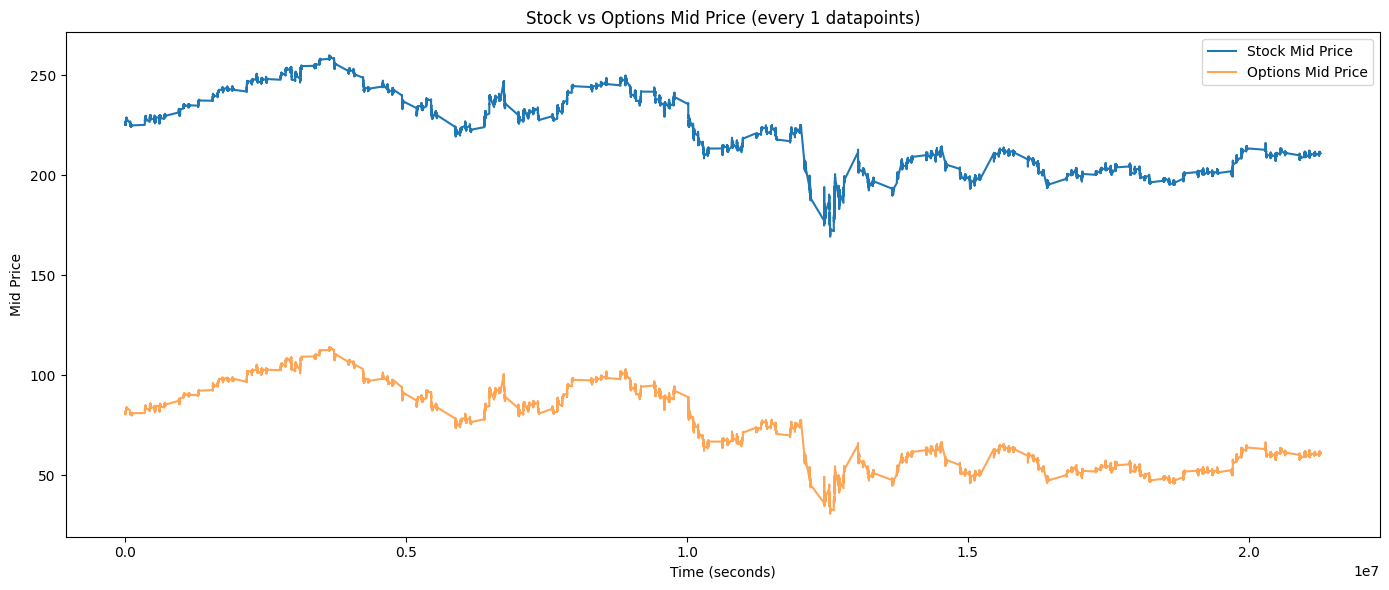

In [2]:
# Helper to safely convert numeric values
def to_float(x):
    try:
        return float(x)
    except ValueError:
        return None

# --- Load stock data ---
df_stock = pd.read_csv(
    "../../data/AAPL/aapl_stock.csv",
    converters={'bid': to_float, 'ask': to_float},
    dtype={'date': str, 'ms_of_day': str}  # ensure datetime strings
)

# Combine date + time into datetime column
df_stock['datetime'] = pd.to_datetime(
    df_stock['date'] + ' ' + df_stock['ms_of_day'], errors='coerce'
)

# Keep only valid rows
df_stock = df_stock.dropna(subset=['datetime', 'bid', 'ask'])
df_stock['mid_price'] = (df_stock['bid'] + df_stock['ask']) / 2
df_stock['mid_price'] = df_stock['mid_price'].replace(0, pd.NA)
df_stock['mid_price'] = df_stock['mid_price'].bfill()

# --- Load options data ---
df_options = pd.read_csv(
    "../../data/AAPL/aapl_options.csv",
    converters={'bid': to_float, 'ask': to_float},
    dtype={'date': str, 'ms_of_day': str}
)
df_options['datetime'] = pd.to_datetime(
    df_options['date'] + ' ' + df_options['ms_of_day'], errors='coerce'
)
df_options = df_options.dropna(subset=['datetime', 'bid', 'ask'])
df_options['mid_price'] = (df_options['bid'] + df_options['ask']) / 2
df_options['mid_price'] = df_options['mid_price'].replace(0, pd.NA)
df_options['mid_price'] = df_options['mid_price'].bfill()

# --- Align stock and options on datetime (nearest) ---
df_merged = pd.merge_asof(
    df_stock.sort_values("datetime"),
    df_options.sort_values("datetime")[["datetime", "mid_price"]],
    on="datetime",
    direction="nearest",
    suffixes=("_stock", "_options")
)

# --- Convert to numpy arrays with downsampling ---
def get_paths(df, skip=1):
    # Time in seconds from start
    t_path = (df["datetime"] - df["datetime"].iloc[0]).dt.total_seconds().to_numpy()
    S_path = df["mid_price_stock"].to_numpy()
    u_path = df["mid_price_options"].to_numpy()
    
    # Downsample (keep every skip-th point)
    return t_path[::skip], S_path[::skip], u_path[::skip]

# Example usage
skip = 1  # keep one point every 10 datapoints
t_path, S_path, u_path = get_paths(df_merged, skip=skip)

# --- Optional: Plot (just for visualization) ---
plt.figure(figsize=(14,6))
plt.plot(t_path, S_path, label="Stock Mid Price")
plt.plot(t_path, u_path, label="Options Mid Price", alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Mid Price")
plt.title(f"Stock vs Options Mid Price (every {skip} datapoints)")
plt.legend()
plt.tight_layout()
plt.show()


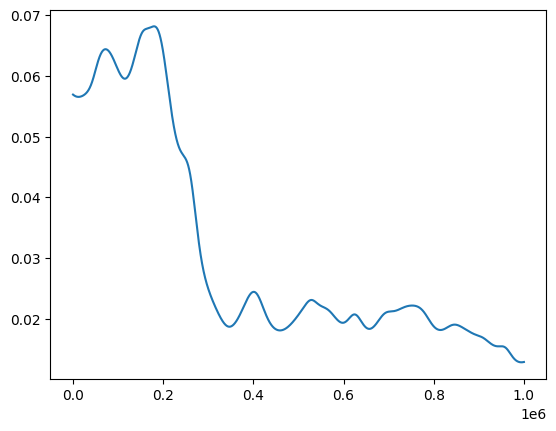

In [3]:
sigma_vals = estimate_diffusion_unprocessed(S_path, t_path, time_threshold=skip, n_grid=1_000_000)
plt.figure(figsize=(14,6))
plt.plot(t_path, sigma_vals)

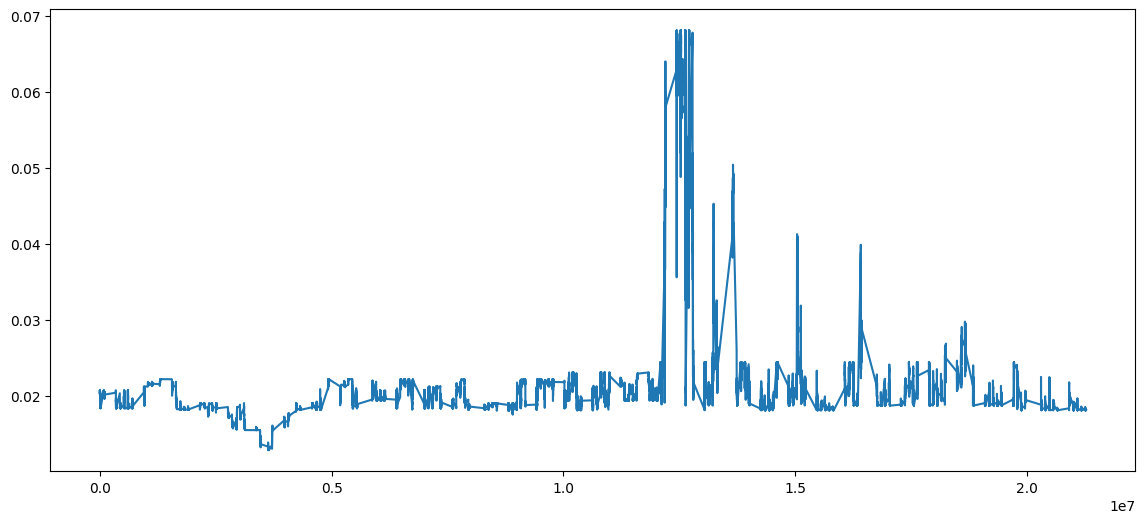

In [6]:

def extract_brownian_XD(assumed_r, S_path, sigma_estimate, dt):
    drift_term = assumed_r * S_path[:-1] * dt

    recovered_dB = (np.diff(S_path) - drift_term) / (sigma_estimate[:-1] * S_path[:-1])

    return recovered_dB

#### Verifying FFT estimation correctness

In [2]:
from src.utils.sigma_estimation import estimate_diffusion_fft

In [19]:
def black_scholes_solution_vectorized(s_array, K, T_to_maturity, r, sigma_val):
    """Analytical solution for European call option price."""
    tau = np.maximum(T_to_maturity, 1e-9)
    d1 = (np.log(s_array / K) + (r + 0.5 * sigma_val ** 2) * tau) / (sigma_val * np.sqrt(tau))
    d2 = d1 - sigma_val * np.sqrt(tau)
    call_price = s_array * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    # At maturity (T_to_maturity <= 0), the price is the payoff
    return np.where(T_to_maturity <= 0, np.maximum(s_array - K, 0), call_price).astype(np.float64)

def sigma_func(X):
    return np.sqrt(X)

T = 1
N_SIM = 1_000_000
R = 0.1
K = 102

dt = T / N_SIM
t_path = np.linspace(0, T, N_SIM, dtype=np.float64)

# Initialize stock price path
s_path = np.zeros(N_SIM, dtype=np.float64)
s_path[0] = 100

# Generate path using Euler-Maruyama for Geometric Brownian Motion
db_path = np.random.normal(0, np.sqrt(dt), size=(N_SIM - 1))
for i in range(N_SIM - 1):
    s_path[i + 1] = s_path[i] + R * s_path[i] * dt + sigma_func(s_path[i]) * db_path[i]

# Calculate option price path using the analytical Black-Scholes solution
# u_path = black_scholes_solution_vectorized(s_path, K, cfg.T - t_path, cfg.R, cfg.SIGMA_VAL)

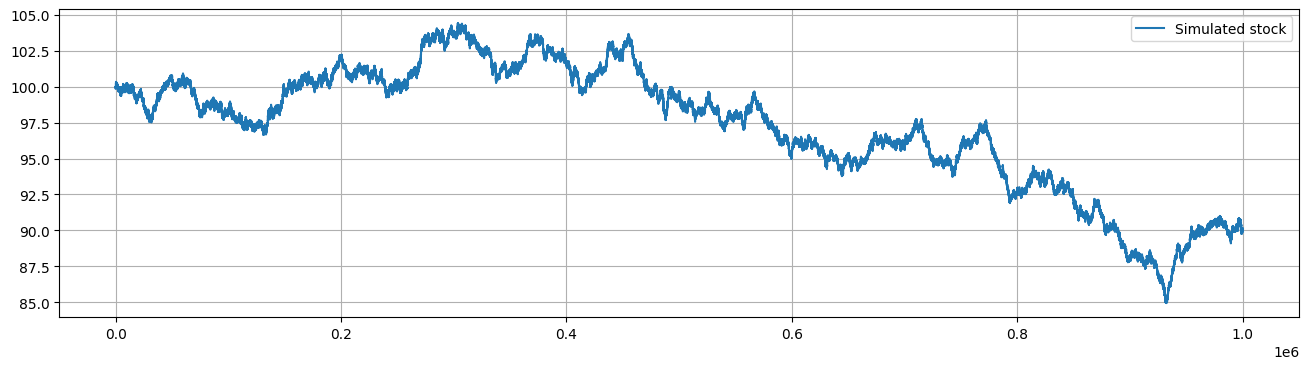

In [20]:
plt.figure(figsize=(16,4))
plt.plot(s_path, label="Simulated stock")
plt.grid()
plt.legend()
plt.show()

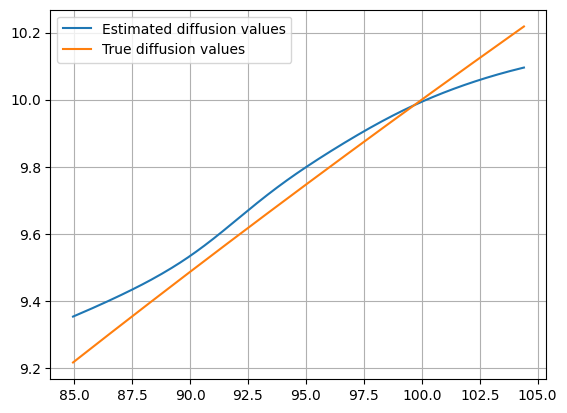

In [21]:
s_grid, sigma_vals = estimate_diffusion_fft(s_path[:-1], (np.diff(s_path) ** 2) / dt, bandwidth=2.5)

plt.plot(s_grid, sigma_vals, label="Estimated diffusion values")
plt.plot(s_grid, sigma_func(s_grid), label="True diffusion values")
plt.grid()
plt.legend()
plt.show()

Plotting the stock path with gaps...


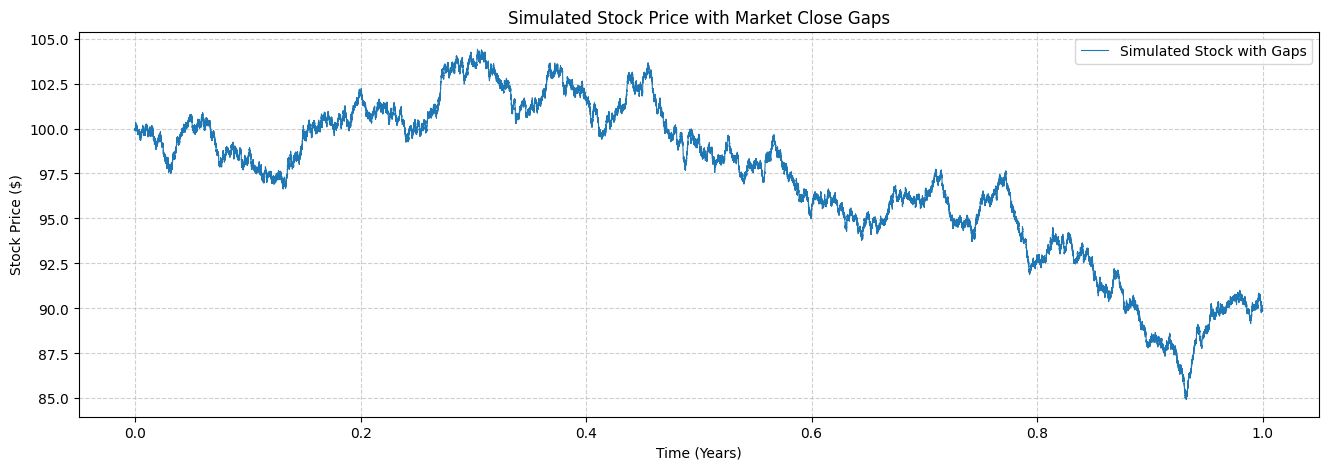

In [22]:
STEPS_PER_TRADING_DAY = 100 
STEPS_PER_GAP = 50

# Introduce Gaps into the Data
total_period = STEPS_PER_TRADING_DAY + STEPS_PER_GAP
num_periods = N_SIM // total_period

indices_to_keep = []
for i in range(num_periods):
    start_index = i * total_period
    end_index = start_index + STEPS_PER_TRADING_DAY
    indices_to_keep.extend(range(start_index, end_index))


s_path_gappy = s_path[indices_to_keep]
t_path_gappy = t_path[indices_to_keep]


print("Plotting the stock path with gaps...")
plt.figure(figsize=(16, 5))
plt.plot(t_path_gappy, s_path_gappy, label="Simulated Stock with Gaps", linewidth=0.8)
plt.title("Simulated Stock Price with Market Close Gaps")
plt.xlabel("Time (Years)")
plt.ylabel("Stock Price ($)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

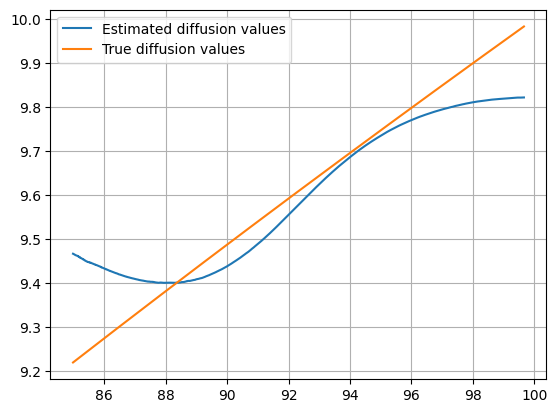

In [23]:
time_threshold = min(np.diff(t_path_gappy))
s_grid, sigma_on_grid, sigma_vals = estimate_diffusion_unprocessed(s_path_gappy, t_path_gappy, time_threshold=time_threshold)

plt.plot(s_grid, sigma_on_grid, label="Estimated diffusion values")
plt.plot(s_grid, sigma_func(s_grid), label="True diffusion values")
plt.grid()
plt.legend()
plt.show()